In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import glob
import math

# Define Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)].detach()

# Define Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, max_len=1000):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size, max_len=max_len)
        self.transformer = nn.Transformer(d_model=hidden_size, nhead=2, num_encoder_layers=num_layers, num_decoder_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer(x)
        x = self.fc(x)
        return x


C:\Users\drodel\AppData\Local\Temp\ipykernel_2408\4103234719.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
base_path = r"..\dat\merged"
# Define IMU Dataset
class IMUDataset(Dataset):
    def __init__(self, folder_path):
        self.sequences = []
        for txt_file in glob.glob(os.path.join(folder_path, '*.txt')):
            # left out: 'qx', 'qy', 'qz', 'qw'
            sequence = pd.read_csv(txt_file, usecols=['ax(m/s^2)', 'ay(m/s^2)', 'az(m/s^2)', 'gx(rad/s)', 'gy(rad/s)', 'gz(rad/s)', 'px', 'py', 'pz'], sep=' ').values
            self.sequences.append(sequence)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sample = torch.tensor(self.sequences[idx], dtype=torch.float32)
        return sample

# Prepare Datasets and Data Loaders
train_dataset = IMUDataset(os.path.join(base_path, 'train'))
val_dataset = IMUDataset(os.path.join(base_path, 'val'))
test_dataset = IMUDataset(os.path.join(base_path, 'test'))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Batch size is set to 1 for sequence-level processing
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [9]:
next(iter(train_loader)).shape

torch.Size([1, 5256, 9])

In [32]:
example_csv = pd.read_csv(r"C:\Users\drodel\Documents\Studium\Tuebingen\Semester_1__WS_2023\Virtual Humans\Exercises\Project_VH\IMU-Based-Tracking-of-Objects\dat\merged\train\bike-easy-vi_merged.txt", sep=' ') # usecols=['ax(m/s^2)', 'ay(m/s^2)', 'az(m/s^2)', 'gx(rad/s)', 'gy(rad/s)', 'gz(rad/s)', 'px', 'py', 'pz'], sep=' ')

In [50]:
example_csv['time_diff'] = example_csv['time(us)'].diff(1)
example_csv.loc[example_csv['time_diff'] > 1e5]

,time(us),gx(rad/s),gy(rad/s),gz(rad/s),ax(m/s^2),ay(m/s^2),az(m/s^2),temperature,px,py,pz,qx,qy,qz,qw,time_diff
3008,2.628194e+07,0.880565,-0.167506,-0.085210,9.658519,-0.694135,-1.591767,27.140625,-1.394293,0.397834,1.991056,0.189599,-0.149601,0.957892,-0.155286,200000.0
3009,2.603403e+08,-0.029942,-0.244960,0.068763,11.661551,0.837530,-2.416141,18.513672,-1.461425,0.530616,1.984876,0.163238,-0.221564,0.950284,0.145678,234058334.0


<Axes: >

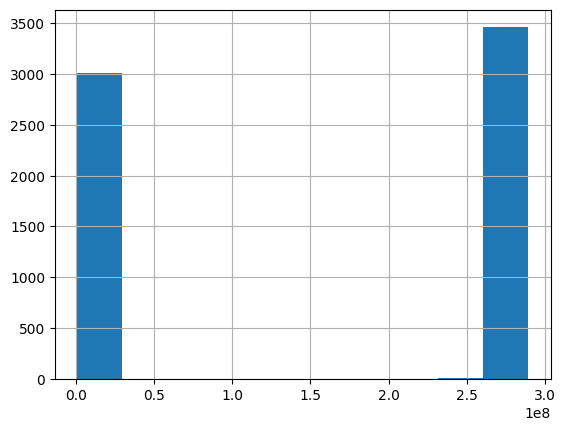

In [35]:
example_csv['time(us)'].hist()

In [18]:
example_batch = next(iter(train_loader))
example_batch.shape

torch.Size([1, 5872, 9])

In [29]:
# Initialize the model with positional encoding
input_size = 9  # Assuming 3 values for each of acceleration, gyroscope, and position
hidden_size = 64
num_layers = 2
output_size = 3  # Assuming 3 values for x, y, z position

model = TransformerModel(input_size, hidden_size, num_layers, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input, target = batch[:,:1000,:-3], (batch[:,:1000,-3:]-batch[0,0,-3:])
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)  # Assuming the last 3 columns are for position
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            input, target = batch[:,:1000,:-3], (batch[:,:1000,-3:]-batch[0,0,-3:])
            output = model(input)
            val_loss += criterion(output, target).item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss / len(val_loader)}')

# # Testing
# model.eval()
# with torch.no_grad():
#     test_loss = 0
#     for batch in test_loader:
#         input, target = batch[:,:,:-3], (batch[:,:,-3:]-batch[0,0,-3:])
#         output = model(input)
#         test_loss += criterion(output, target).item()

# print(f'Test Loss: {test_loss / len(test_loader)}')

# # Making predictions
# model.eval()
# with torch.no_grad():
#     for batch in test_loader:
#         predictions = model(batch)
#         # Process predictions as needed


c:\Users\drodel\Documents\Studium\Tuebingen\Semester_1__WS_2023\Virtual Humans\Exercises\Project_VH\IMU-Based-Tracking-of-Objects\venv\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x6 and 9x64)